<a href="https://colab.research.google.com/github/conormj14/AI-POWERED-DV360-Reach-Overlap-Analysis-Ext-Version-/blob/main/Ext_Version_MU_DV360_Reach_Overlap_AI_Powered_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **WELCOME TO THE AI POWERED DV360 Reach Overlap Analysis Notebook**

# Analysis Filters

In [ ]:
CLIENT_NAME = "Reckitt" #@param {type:"string"}
YOUR_NAME = 'Rom' #@param {type:"string"}
RECEIVER_NAME = 'Reckitt' #@param {type:"string"}
GOOGLE_SHEET_NAME = "DV360 MU/Reach Overlap Insights "  #@param {type:"string"}
INCLUDE_ROWS_CONTAINING = ''  #@param {type:"string"}
INCLUDE_COLS_CONTAINING = ''  #@param {type:"string"}
EXCLUDE_ROWS_CONTAINING = '' #@param {type:"string"}
EXCLUDE_COLS_CONTAINING = '' #@param {type:"string"}
#set the below filter to Insertion Order or Advertiser
COMPARISON_DIMENSION = 'Insertion Order' # @param ["Insertion Order", "Advertiser"]
BAR_CHARTS_WIDTH_IN_PIXELS = 1800 #@param {type:"integer"}
BAR_CHARTS_HEIGHT_IN_PIXELS  = 1000 #@param {type:"integer"}
ALL_IOs_HEATMAP_SIZE = 'Medium' # @param ["Small", "Medium", "Large"]
FILTERED_IOS_HEATMAP_SIZE = 'Medium' # @param ["Small", "Medium", "Large"]
VENN_DIAGRAM_IO_ONE = "" #@param {type:"string"}
VENN_DIAGRAM_IO_TWO = "" #@param {type:"string"}

## Interactive Trix & Packages

In [ ]:
# @title
#importing pandas
#importing sheets package from the colab library and defining your sheet
#make sure to edit the name of the google_sheet_name variable below and that the sheet generates correctly below
from google.colab import auth
auth.authenticate_user()
from google.colab import sheets
from google import genai
from google.genai import types
from google.colab import userdata
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from datetime import datetime
from IPython.display import display, Markdown
import ipywidgets as widgets
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px




#setting current date
current_date = datetime.now()
#Formatting current date to DD-MM-YY format
formatted_date = current_date.strftime("%d/%m/%y")

#Setting sheet name variable based off global sheet name from input text boxes
google_sheet_name = GOOGLE_SHEET_NAME


#Defining pandas dataframes based on colabs interactive google sheet functionality
overlap_df = sheets.InteractiveSheet(title=google_sheet_name, worksheet_name='Reach_Overlap').as_df()
#overlap_df = reach_overlap_ws
ar_df = sheets.InteractiveSheet(title=google_sheet_name, worksheet_name='Added_Reach_Raw_Data').as_df()
spend_df = sheets.InteractiveSheet(title=google_sheet_name, worksheet_name='Spend_Raw_Data').as_df()
weekly_reach_df = sheets.InteractiveSheet(title=google_sheet_name, worksheet_name='Weekly_Reach').as_df()


https://docs.google.com/spreadsheets/d/18LSYbpfC_1fcNZliaUam8PzTlB6P9sGqZxnYsNWvGEA/edit#gid=145103463


https://docs.google.com/spreadsheets/d/18LSYbpfC_1fcNZliaUam8PzTlB6P9sGqZxnYsNWvGEA/edit#gid=0


https://docs.google.com/spreadsheets/d/18LSYbpfC_1fcNZliaUam8PzTlB6P9sGqZxnYsNWvGEA/edit#gid=1158418801


https://docs.google.com/spreadsheets/d/18LSYbpfC_1fcNZliaUam8PzTlB6P9sGqZxnYsNWvGEA/edit#gid=5083219


####Model Configuration

In [ ]:
# @title

creds = userdata.get('GOOGLE_API_KEY') ##Enter your gemini API keys as Colab secrets
#For instructions on how to get gemini API keys, see documentation on Google AI Studio


##model = genai.GenerativeModel('gemini-2.0-pro-exp-02-05')
#model = genai.GenerativeModel('gemini-2.0-flash-thinking-exp-01-21')
#model = genai.GenerativeModel('gemini-2.0-flash')


client = genai.Client(api_key=creds)

sys_instruct = f"""You are a highly experienced DV360 Specialist. You specialize in crafting and optimizing programmatic advertising strategies that directly drive incremental sales. You have a deep understanding of the digital advertising landscape.

Expertise: Advanced knowledge of programmatic advertising, DV360 platform, audience targeting, campaign optimization, and data analysis. Proven ability to drive incremental sales and demonstrate ROI.

Keep in mind when preparing insights that reach cannot be summed.  High Overlap (Duplicate Reach) is good for building frequency, whereas low overlap (Exclusive Reach) is good for building reach.

Be assertive and confident but approachable and conversational. Use clear, concise language. Aim for a tone that conveys authority and trustworthiness.  Write succinctly and condense paragraphs avoiding jargon or overly formal language.

Ensure output includes:

- A brief introduction that summarizes purpose.
- A bullet-point list of key findings or recommendations.



When prompt starts with "--" please refine the text provided using the above information."""


## Dataframe & Helper Functions

In [ ]:
# @title

def clean_weekly_reach_df(df):
    """
    Converts the 'Week' column to datetime and 'Unique Reach:' columns to specified types.

    Args:
        df: The input pandas DataFrame with weekly reach data.

    Returns:
        A cleaned pandas DataFrame.
    """
    # Convert 'Week' column to datetime, coercing errors to NaT
    df['Week_Start_Date'] = pd.to_datetime(df['Week'].apply(lambda x: x.split(' - ')[0] if isinstance(x, str) and ' - ' in x else None), format='%Y/%m/%d', errors='coerce')

    # Define columns to convert to integer, excluding 'Unique Reach: Average Impression Frequency'
    int_cols = [col for col in df.columns if 'Unique Reach:' in col and col != 'Unique Reach: Average Impression Frequency']

    # Convert specified columns to integer, coercing errors to NaN and then filling NaN with 0
    for col in int_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

    # Convert 'Unique Reach: Average Impression Frequency' to float, coercing errors to NaN and then filling NaN with 0
    df['Unique Reach: Average Impression Frequency'] = pd.to_numeric(df['Unique Reach: Average Impression Frequency'], errors='coerce').fillna(0).astype(float)

    return df

def set_dtypes(df):
  """Takes in a dataframe and converts metric columns to numeric data types
  Args:
    df: The input pandas DataFrame.
  Returns:
    A pandas dataframe"""

  dimension_cols = ['Partner', 'Partner ID', 'Country', 'Advertiser', 'Advertiser ID', 'Campaign', 'Campaign ID', 'Insertion Order', 'Insertion Order ID', 'Advertiser Currency']
  for col in df.columns:
    if col not in dimension_cols:
      try:
        # Attempt to convert to numeric, coercing errors to NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # Replace NaN with 0 after numeric conversion
        df[col] = df[col].fillna(0)
      except Exception as e:
        print(f"Could not convert column {col} to numeric: {e}")
        # If conversion fails, keep the column as is or handle differently
        # For now, we'll keep it as is, it might be object or string
        pass # Or add other handling like df[col] = df[col].astype(str).fillna('')
  return df


def overlap_col_cleaner(df):
  '''Docstring: This function takes in a Dataframe truncates the irrelevant parts of the column names and then replaces any hyphenated values where no reach overlap was observed to a 0.0 float data type. Ouput: Dataframe'''
  new_col_list = []

  for col in df.columns:
    col = col.split(':')[0]
    new_col_list.append(col)

  df.columns = new_col_list

  df = df.apply(lambda x: pd.to_numeric(x.astype(str).str.replace('-', '0.0', regex=False), errors='coerce'))

  return df

#defining a function to filter insertion order names for a given input string so that users can focus the analysis on one part of a clients activity based on their naming conventions
def filter_io_rows(df, row_filter, rows_to_exclude=None):
    """
    Takes in a dataframe and filters it based on inclusion and exclusion filtering critera

    Args:
      df (dataframe): input pandas dataframe
      row_filter (str): Some criteria to filter the rows of the dataframe based on whether the substring is found within the column header string value
      rows_to_exclude (str, optional): Some criteria to exclude the rows of the dataframe based on whether the substring is found within the column header string value. Defaults to None.

    Returns:
      A filtered pandas dataframe that is a copy of the original input dataframe
      """

    filtered_df = df.copy()
    if row_filter:
        mask = filtered_df.index.str.contains(row_filter)
        filtered_df = filtered_df[mask]

    if rows_to_exclude:
        exclude_mask = filtered_df.index.str.contains(rows_to_exclude)
        filtered_df = filtered_df[~exclude_mask]

    return filtered_df


def filter_io_cols(df, col_filter, cols_to_exclude=None):
  """
    Takes in a dataframe and filters it based on inclusion and exclusion filtering critera

    Args:
      df (dataframe): input pandas dataframe
      row_filter (str): Some criteria to filter the columns of the dataframe based on whether the substring is found within the column header string value
      rows_to_exclude (str, optional): Some criteria to exclude the columns of the dataframe based on whether the substring is found within the column header string value. Defaults to None.

    Returns:
      A filtered pandas dataframe that is a copy of the original input dataframe
      """
  filtered_df = df.copy()
  if col_filter:
    filtered_df = filtered_df.filter(like=col_filter)

  if cols_to_exclude:
    cols = [col for col in filtered_df.columns if cols_to_exclude not in col]
    filtered_df = filtered_df[cols]

  return filtered_df

def clean_dataframe(df, metadata_identifier="Report Time:"):
  """
  Cleans the dataframe by dropping rows containing report metadata.

  Args:
    df: The input pandas DataFrame.
    metadata_identifier: A string that identifies the start of
                         metadata rows. Defaults to "Report Time:".

  Returns:
    A cleaned pandas DataFrame with report metadata rows removed.
  """
  # Drop columns with empty string as name
  df = df.drop(columns=[''], errors='ignore')

  # Find the index of the row containing the metadata identifier in the first column (iloc[:, 0])
  # This assumes the metadata identifier is in the first column before setting headers
  metadata_index = df[df.iloc[:, 0].astype(str) == metadata_identifier].index[0]


  # Drop rows starting from the metadata index
  cleaned_df = df.drop(df.index[metadata_index:])

  # Replace empty strings with NaN
  cleaned_df = cleaned_df.replace('', np.nan)
  cleaned_df = cleaned_df.replace('-', np.nan)

  # Drop rows with all NaN values
  cleaned_df = cleaned_df.dropna(how='all')

  return cleaned_df



###Cleaning the dataframes

In [ ]:
# @title
# Apply the cleaning function to weekly_reach_df
weekly_reach_df = clean_weekly_reach_df(weekly_reach_df)
#Apply df cleaner func to other dfs
ar_df = clean_dataframe(ar_df, metadata_identifier="Report Time:")
ar_df = set_dtypes(ar_df)
spend_df = clean_dataframe(spend_df, metadata_identifier="Report Time:")
spend_df = set_dtypes(spend_df)
overlap_df = clean_dataframe(overlap_df, metadata_identifier="Report Time:")
overlap_df = set_dtypes(overlap_df)

print("Dataframes have been successfully cleaned!")

Dataframes have been successfully cleaned!


###Weekly Reach Visualisation Campaign Filter (Note: You have to cahnge the filter and then run the weekly reach graph cell again to change the graph)

In [ ]:
# @title


# Create a dropdown widget for the 'Campaign' column in weekly_reach_df
camp_dropdown = widgets.Dropdown(
    options=weekly_reach_df['Campaign'].unique().tolist(),
    description='Campaign:',
    disabled=False,
)


# Display the dropdown
display(camp_dropdown)

Dropdown(description='Campaign:', options=('US_EN_ALL_Free_BRA_EDUDEMEXP_Programmatic_FY25_3Q4Q_LYW3.0-MK25-00…

##Reach & Frequency Time Series Analysis

In [ ]:
# @title

SELECTED_CAMPAIGN = camp_dropdown.value

# Drop rows where 'Week_Start_Date' is NaT (invalid date entries)
weekly_reach_df = weekly_reach_df.dropna(subset=['Week_Start_Date'])

# Filter the DataFrame based on the selected campaign
filtered_weekly_reach_df = weekly_reach_df[weekly_reach_df['Campaign'] == SELECTED_CAMPAIGN]

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add bars for Impression Reach
fig.add_trace(
    go.Bar(x=filtered_weekly_reach_df['Week_Start_Date'], y=filtered_weekly_reach_df['Unique Reach: Impression Reach'], name='Unique Reach'),
    secondary_y=False,
)

# Add bars for Incremental Reach
fig.add_trace(
    go.Bar(x=filtered_weekly_reach_df['Week_Start_Date'], y=filtered_weekly_reach_df['Unique Reach: Incremental Impression Reach'], name='Incremental Reach'),
    secondary_y=False,
)

# Add lines for Average Impression Frequency
fig.add_trace(
    go.Scatter(x=filtered_weekly_reach_df['Week_Start_Date'], y=filtered_weekly_reach_df['Unique Reach: Average Impression Frequency'], name='Average Frequency', marker=dict(size=10)),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Reach and Frequency Over Time: " + SELECTED_CAMPAIGN
)

# Set x-axis title
fig.update_xaxes(title_text="Week")

# Set y-axes titles
fig.update_yaxes(title_text="Unique Reach (Users)", secondary_y=False)
fig.update_yaxes(title_text="Average Frequency", secondary_y=True)

fig.show()

###Media Unification Dataframe

In [ ]:
# @title
mu_df = ar_df.merge(spend_df, on='Campaign ID', how='left', suffixes=(None, "_y")).drop(columns=['Advertiser_y', 'Advertiser ID_y', 'Campaign_y'])
mu_df = mu_df.replace('-', 0,inplace=False)
mu_df = mu_df.astype({'Unique Reach: Added Impression Reach From Frequency Cap': int, 'Unique Reach: Impression Reach':int,'Unique Reach: Impression Reach (Co-Viewed)':int, 'Revenue (Adv Currency)':float, 'Media Cost (Advertiser Currency)':float, 'Platform Fee (Adv Currency)':float})
#mu_df = pd.to_numeric(mu_df[['Unique Reach: Added Impression Reach From Frequency Cap', 'Unique Reach: Impression Reach']], errors='coerce')
#dropping rows with 0 reach
mu_df = mu_df[mu_df['Unique Reach: Impression Reach'] != 0].reset_index(drop=True)
#dropping rows with 0 spend
mu_df = mu_df.dropna(subset=['Revenue (Adv Currency)']).reset_index(drop=True)
#rounding revenue spend to 2 decimals
mu_df['Revenue (Adv Currency)'] = round(mu_df['Revenue (Adv Currency)'],2)
#adding baseline_reach
mu_df['baseline_reach'] = mu_df['Unique Reach: Impression Reach'] - mu_df['Unique Reach: Added Impression Reach From Frequency Cap']
#adding CPU baseline
mu_df['CPU_baseline'] = round(mu_df['Revenue (Adv Currency)'] / mu_df['baseline_reach'],2)
#adding reach savings
mu_df['reach_savings'] = round(mu_df['Unique Reach: Added Impression Reach From Frequency Cap'] * mu_df['CPU_baseline'],2)
#adding added reach percentage
mu_df['added_reach_percentage'] = round(mu_df['Unique Reach: Added Impression Reach From Frequency Cap'] / mu_df['Unique Reach: Impression Reach'],2)
#adding media_fees
mu_df['total_media_fees'] = round(mu_df['Revenue (Adv Currency)'] - mu_df['Media Cost (Advertiser Currency)'],2)
#checking output df
mu_df.head()

,Partner,Partner ID,Country,Advertiser,Advertiser ID,Campaign,Campaign ID,Unique Reach: Added Impression Reach From Frequency Cap,Unique Reach: Impression Reach,Unique Reach: Impression Reach (Co-Viewed),Advertiser Currency,Revenue (Adv Currency),Media Cost (Advertiser Currency),Platform Fee (Adv Currency),Platform Fee Rate,baseline_reach,CPU_baseline,reach_savings,added_reach_percentage,total_media_fees
0,Canva c/o Jellyfish AU - DV360 - APAC,634702057,US,Canva - Brand - US [USD],662541058,US_EN_ALL_Free_BRA_EDUDEMEXP_Programmatic_FY25...,55977900,32113652,134813306,142667919,USD,8405164.18,8232444.487,499955.7628,0.0,102699654,0.08,2569092.16,0.24,172719.69


from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_0.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Unique Reach: Added Impression Reach From Frequency Cap']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Unique Reach: Added Impression Reach From Frequency Cap'}, axis=1)
              .sort_values('Unique Reach: Added Impression Reach From Frequency Cap', ascending=True))
  xs = counted['Unique Reach: Added Impression Reach From Frequency Cap']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('Unique Reach: Added Impression Reach From Frequency Cap', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Unique Reach: Added Impression Reach From Frequency Cap')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Unique Reach: Impression Reach']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Unique Reach: Impression Reach'}, axis=1)
              .sort_values('Unique Reach: Impression Reach', ascending=True))
  xs = counted['Unique Reach: Impression Reach']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('Unique Reach: Impression Reach', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Unique Reach: Impression Reach')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Unique Reach: Impression Reach (Co-Viewed)']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Unique Reach: Impression Reach (Co-Viewed)'}, axis=1)
              .sort_values('Unique Reach: Impression Reach (Co-Viewed)', ascending=True))
  xs = counted['Unique Reach: Impression Reach (Co-Viewed)']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('Unique Reach: Impression Reach (Co-Viewed)', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Unique Reach: Impression Reach (Co-Viewed)')
_ = plt.ylabel('count()')

In [ ]:
# @title

fig = go.Figure()

fig.add_trace(go.Bar(
    x=mu_df['Campaign'],
    y=mu_df['baseline_reach'],
    name='Baseline Reach',
    marker_color='lightgreen'
))

fig.add_trace(go.Bar(
    x=mu_df['Campaign'],
    y=mu_df['Unique Reach: Added Impression Reach From Frequency Cap'],
    name='Added Reach (Frequency Cap)',
    marker_color='darkgreen'
))

fig.update_layout(
    barmode='stack',
    title_text='Baseline Reach and Added Reach by Campaign',
    xaxis_title="Campaign",
    yaxis_title="Reach",
    legend_title="Reach Type"
)

fig.show()

In [ ]:
# @title
fig = go.Figure()

fig.add_trace(go.Bar(
    x=mu_df['Campaign'],
    y=mu_df['reach_savings'],
    name='Reach Savings Value',
    marker_color='lightgreen'
))

fig.add_trace(go.Bar(
    x=mu_df['Campaign'],
    y=mu_df['Platform Fee (Adv Currency)'],
    name='Platform Fees',
    marker_color='darkgreen'
))

fig.update_layout(

    title_text='Reach Savings vs Media Fees',
    xaxis_title="Campaign",
    yaxis_title="$",
    legend_title="Media Unification Value Quantification"
)

fig.show()

In [ ]:
# @title
total_reach_savings = mu_df['reach_savings'].sum()
total_added_reach_pct = mu_df['Unique Reach: Added Impression Reach From Frequency Cap'].sum() / mu_df['baseline_reach'].sum()
total_media_fees = mu_df['Revenue (Adv Currency)'].sum() - mu_df['Media Cost (Advertiser Currency)'].sum()
total_platform_fees = mu_df['Platform Fee (Adv Currency)'].sum()

display(Markdown(f"# Total Reach Savings: ${total_reach_savings:,.2f}"))
display(Markdown(f"# Total Media Fees: ${total_media_fees:,.2f}"))
display(Markdown(f"# Total Platform Fees: ${total_platform_fees:,.2f}"))
display(Markdown(f"# Total Added Reach Pct: {total_added_reach_pct:.0%}"))

# Total Reach Savings: $2,569,092.16

# Total Media Fees: $172,719.69

# Total Platform Fees: $499,955.76

# Total Added Reach Pct: 31%

In [ ]:
# @title

fig = go.Figure(data=[
    go.Bar(name='Total Reach Savings', x=['Metrics'], y=[total_reach_savings], marker_color='green'),
    go.Bar(name='Total Platform Fees', x=['Metrics'], y=[total_platform_fees])
])

fig.update_layout(barmode='group', title='Comparison of Total Reach Savings and Total Media Fees')
fig.show()

Reach Overlap Venn Diagram (IO_1 vs IO_2)

In [ ]:
# @title
if VENN_DIAGRAM_IO_ONE != '' and VENN_DIAGRAM_IO_TWO != '':
  io_1 = VENN_DIAGRAM_IO_ONE
  io_2 = VENN_DIAGRAM_IO_TWO

  try:
    vd_metrics_df = overlap_df[overlap_df['Insertion Order'].isin([io_1, io_2])][['Insertion Order','Unique Reach: Duplicate Total Reach', 'Unique Reach: Exclusive Total Reach', io_1 + ': Unique Reach: Overlap Total Reach', io_2 + ': Unique Reach: Overlap Total Reach']]
    vd_metrics_df['Unique Reach'] = vd_metrics_df['Unique Reach: Duplicate Total Reach'] + vd_metrics_df['Unique Reach: Exclusive Total Reach']
    vd_metrics_df = vd_metrics_df.rename(columns={'Unique Reach: Duplicate Total Reach': 'Duplicate Total Reach', 'Unique Reach: Exclusive Total Reach': 'Exclusive Total Reach', io_1 + ': Unique Reach: Overlap Total Reach': io_1 + ': Overlap Reach',io_2 + ': Unique Reach: Overlap Total Reach':  io_2 + ': Overlap Reach' })
    vd_metrics_df = vd_metrics_df.drop(columns=['Duplicate Total Reach', 'Exclusive Total Reach'])

    io_1_df = vd_metrics_df[vd_metrics_df['Insertion Order'] == io_1]
    io_2_df = vd_metrics_df[vd_metrics_df['Insertion Order'] == io_2]

    plt.figure(figsize=(15,15))

    set_a = io_1_df['Unique Reach'].sum()
    set_b = io_2_df['Unique Reach'].sum()
    set_c = io_1_df[io_2 + ': Overlap Reach'].sum()

    v = venn2(subsets=(set_a,set_b,set_c), set_labels=(io_1+' Unique Reach',io_2+' Unique Reach', 'Reach Overlap'))

    # Customize labels
    for text in v.set_labels:
        text.set_fontsize(12)
    #these are the numbers in the circles
    for text in v.subset_labels:
        if text:
            text.set_fontsize(14)


    plt.title('Reach Overlap Venn Diagram (Unique Users)')
    plt.show()

  except KeyError as e:
    #handling key errors that may arise from the fact that the venn diagram filter input cannot be found in the sheet
    print("Could not find the value(s) of VENN_DIAGRAM_IO_ONE and/or VENN_DIAGRAM_IO_TWO filters within the google sheet. Please ensure these values exactly match (case sensitive) what is in your 'Insertion Order' or 'Advertiser' column of your sheet before re-running.")
    print("You can also run the cells below if you wish to skip this part of the analysis or simply leave the venn diagram filters blank and run all cells again")
    print(f"Invalid input. Details: {e}")



## Venn Diagram Gemini AI Insights

In [ ]:
# @title

try:
  if VENN_DIAGRAM_IO_ONE != '' and VENN_DIAGRAM_IO_TWO != '':
    csv_data = vd_metrics_df.to_csv(index=False)

    prompt = f"""
    Analyze the following DV360 reach overlap data:
    {csv_data}

    There are three sets as defined by the following code:

    io_1_df = vd_metrics_df[vd_metrics_df['Insertion Order'] == io_1]
    io_2_df = vd_metrics_df[vd_metrics_df['Insertion Order'] == io_2]

    set_a = io_1_df['Unique Reach'].sum()
    set_b = io_2_df['Unique Reach'].sum()
    set_c = io_1_df[io_2 + ' Overlap Total Reach'].sum()

    v = venn2(subsets=(set_a,set_b,set_c), set_labels=(io_1+' Unique Reach',io_2+' Unique Reach', 'Reach Overlap'))

    Note that you cannot just add the unique reach values of each set. Write concise insights into this data.

    """

    response = client.models.generate_content(
      model="gemini-2.0-flash",
      config=types.GenerateContentConfig(
          system_instruction=sys_instruct),
      contents=prompt)

    #response = model.generate_content(prompt)
    vd_insights = response.text
    print(vd_insights)
except NameError as e:
  print('Cannot find data for venn diagram comparison. Please check the data for the two insertion orders you wish to compare is in your sheet and that the names of these are exactly matching in the notebook venn diagram filters')
  print(f"Invalid input. Details: {e}")

### Underlying Venn Diagram Data


In [ ]:
# @title

try:
  if VENN_DIAGRAM_IO_ONE != '' and VENN_DIAGRAM_IO_TWO != '':
    display(vd_metrics_df)
except KeyError as e:
    #handling key errors that may arise from missing 'Insertion Order' or 'Advertiser' errors
    print('Could not find the Insertion Order and/or Advertiser columns in your sheets')
    print(f"Invalid input. Details: {e}")




#Exclusive Reach

In [ ]:
# @title

try:
  #Create the bar plot
  fig = px.bar(overlap_df, x=COMPARISON_DIMENSION, y='Unique Reach: Exclusive Total Reach', color='Unique Reach: Exclusive Total Reach', title=COMPARISON_DIMENSION + ' Exclusive Reach', width=BAR_CHARTS_WIDTH_IN_PIXELS, height=BAR_CHARTS_HEIGHT_IN_PIXELS, color_continuous_scale='darkmint')
  fig.show()
except ValueError as e:
    #handling key errors that may arise from missing 'Insertion Order' or 'Advertiser' errors
    print('Could not find the Insertion Order and/or Advertiser values within those columns in your sheets')
    print(f"Invalid input. Details: {e}")

##Gemini AI Exclusive Reach Insights

In [ ]:
# @title

try:

  csv_data = overlap_df.to_csv(index=False)

  prompt = f"""
  Analyze the following DV360 exclusive reach data:
  {csv_data}

  Each of the numerical data in the cells of this csv is representing the exclusive reach that an advertising buy resulted in.

  Higher exclusive reach values can be good if an advertiser wants to increase their overall unique reach.

  Write some insights into this data and give suggestions on budget optimisation based on the level of exclusive reach between insertion orders.

  """

  response = client.models.generate_content(
      model="gemini-2.0-flash",
    config=types.GenerateContentConfig(
          system_instruction=sys_instruct),
      contents=prompt)


  exc_reach_insights = response.text
  print(exc_reach_insights)
except NameError as e:
  print('Cannot find Unique Reach: Exclusive Reach data within your sheet')
  print(f"Invalid input. Details: {e}")

#Duplicate Reach

In [ ]:
# @title
#Create the bar plot

try:
  fig = px.bar(overlap_df, x=COMPARISON_DIMENSION, y='Unique Reach: Duplicate Total Reach', color='Unique Reach: Duplicate Total Reach', title=COMPARISON_DIMENSION + ' Duplicate Reach', width=BAR_CHARTS_WIDTH_IN_PIXELS, height=BAR_CHARTS_HEIGHT_IN_PIXELS,  color_continuous_scale='darkmint')
  fig.show()
except ValueError as e:
    #handling key errors that may arise from missing 'Insertion Order' or 'Advertiser' errors
    print('Could not find the Insertion Order and/or Advertiser values within those columns in your sheets')
    print(f"Invalid input. Details: {e}")

##Gemini AI Duplicate Reach Insights

---




In [ ]:
# @title

try:
  csv_data = overlap_df.to_csv(index=False)

  prompt = f"""
  Analyze the following DV360 duplicate reach data:
  {csv_data}

  Each of the numerical data in the cells of this csv is representing the duplicate reach that an advertising buy resulted in.

  Higher duplicate reach values can be good if an advertiser wants to increase their ad frequency but lower duplicate reach values are better for increasing overall advertising reach.

  Write some insights into this data and give suggestions on budget optimisation based on the level of duplicate reach between insertion orders.

  """

  '''response = client.models.generate_content(
      model="gemini-2.0-flash",
      config=types.GenerateContentConfig(
          system_instruction="You are a DV360 marketing analyst at Google"),
      contents=prompt)'''

  response = client.models.generate_content(
      model="gemini-2.0-flash",
      config=types.GenerateContentConfig(
          system_instruction=sys_instruct),
      contents=prompt)

  dup_reach_insights = response.text
  print(dup_reach_insights)
except NameError as e:
  print('Cannot find Unique Reach: Duplicate Reach data within your sheet')
  print(f"Invalid input. Details: {e}")

Okay, I've analyzed the DV360 duplicate reach data you provided. Here's a breakdown of key findings and recommendations for budget optimization:

*   **Purpose:** To analyze duplicate reach across various insertion orders and provide budget optimization recommendations to maximize either frequency or overall reach, depending on the campaign goals.

**Key Findings & Recommendations:**

*   **High Overlap within Audio Buys:**  Several audio insertion orders show significant overlap, especially among AudacyStreamingPGKWs, AudacyStreamingPGSMBs, and AudacyStreamingPGSolos (around 0.6-1.0 overlap). iHeartMediaStreamingPGKWs, iHeartMediaStreamingPGSMBs, and iHeartMediaStreamingPGSolos have a 1.0 overlap. This indicates that users are frequently exposed to ads across these platforms.

    *   **Recommendation:**  If the goal is frequency, maintain the current budget allocation. However, if the goal is to expand reach within audio, consider reducing budget from the platforms with the highest o


 **DV360 Reach Overlap Heatmap** 👐

---



## All Insertion Orders Heatmap

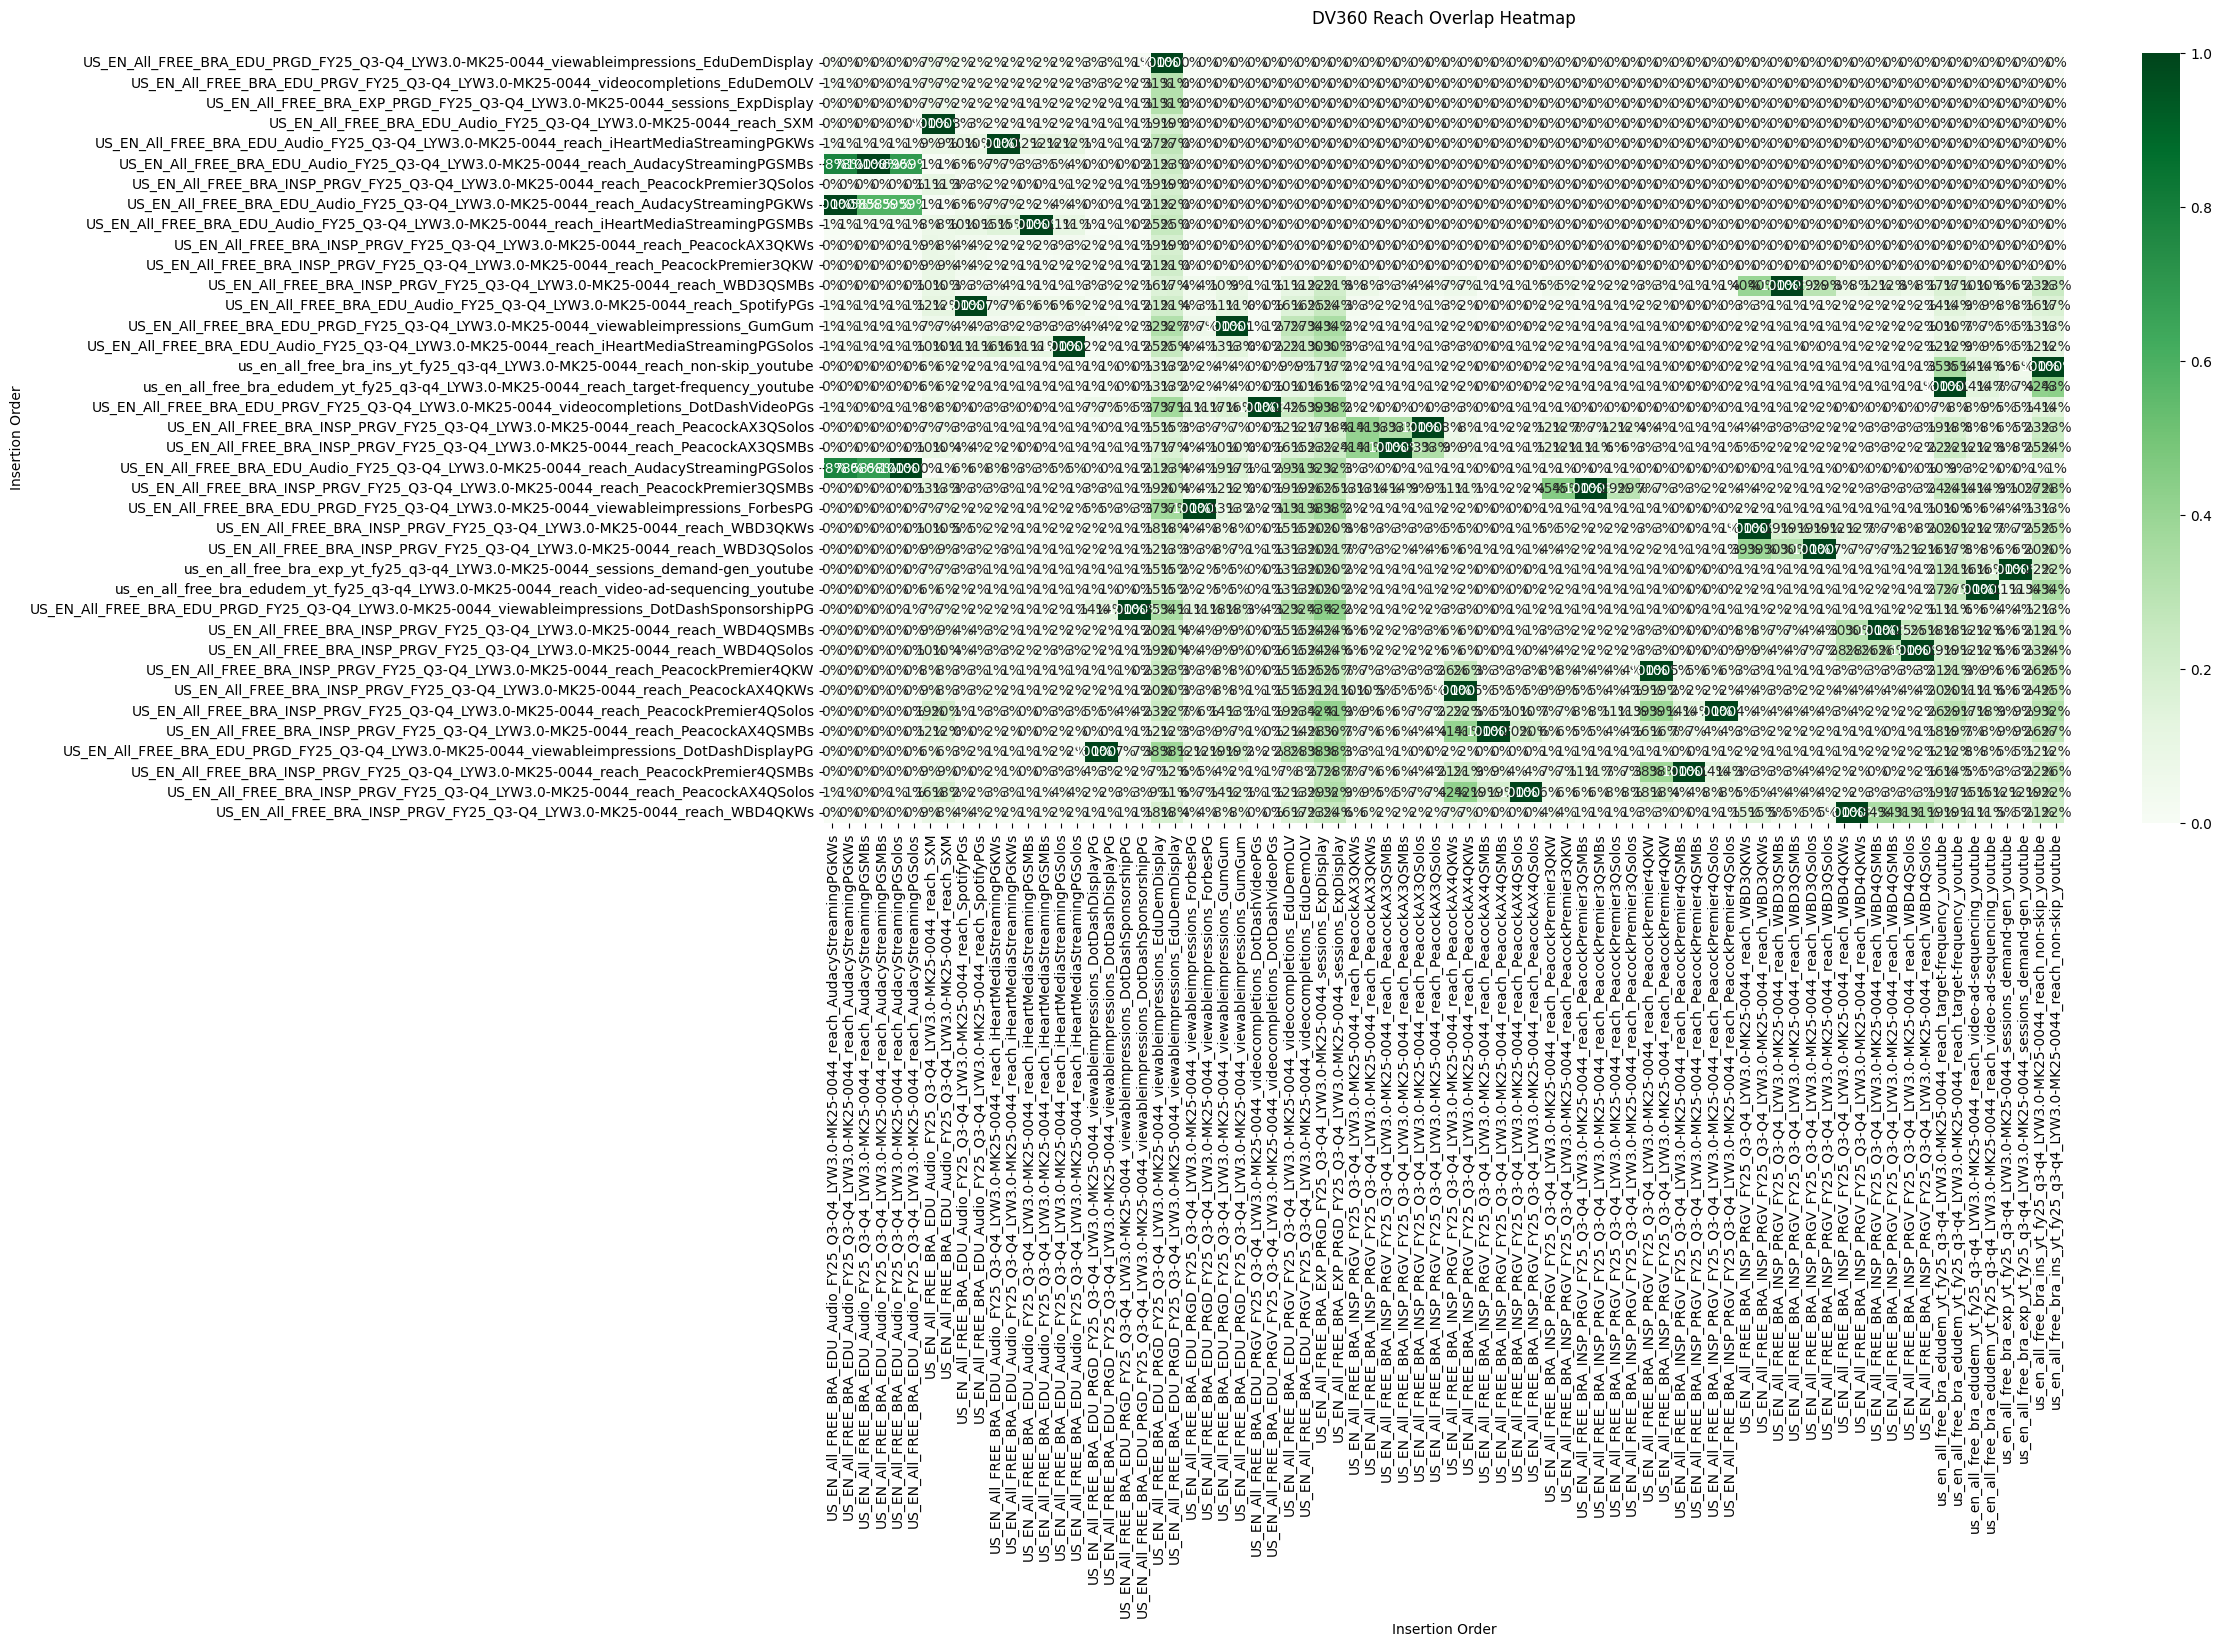

In [ ]:
# @title

try:
  overlap_heatmap_df = overlap_df.set_index(COMPARISON_DIMENSION)\
  .filter(like='Percent', axis=1)

  cleaned_df = overlap_col_cleaner(overlap_heatmap_df)
  #control flow for figure size
  if ALL_IOs_HEATMAP_SIZE == 'Small':
    plt.figure(figsize=(10, 5))
  elif ALL_IOs_HEATMAP_SIZE == 'Medium':
    plt.figure(figsize=(20, 10))
  else:
    plt.figure(figsize=(30, 20))

  #generate the heatmap, adjust the figsize parameters below to alter the output e.g plt.figure(figsize=(10, 5)) will generate a heatmap with width 10 inches and height 5 inches
  #plt.figure(figsize=(30,30))
  sns.heatmap(cleaned_df, cmap="Greens", annot=True, fmt=".0%")
  plt.title("DV360 Reach Overlap Heatmap\n")
  plt.xlabel(COMPARISON_DIMENSION)
  plt.ylabel(COMPARISON_DIMENSION)

  #Screenshot the below visualisation into your deck
  plt.show()
except NameError as e:
    #handling key errors that may arise from missing 'Insertion Order' or 'Advertiser' errors
    print('Could not find the Reach Overlap % data within your sheet')
    print(f"Invalid input. Details: {e}")

## Filtered Insertion Orders Heatmap

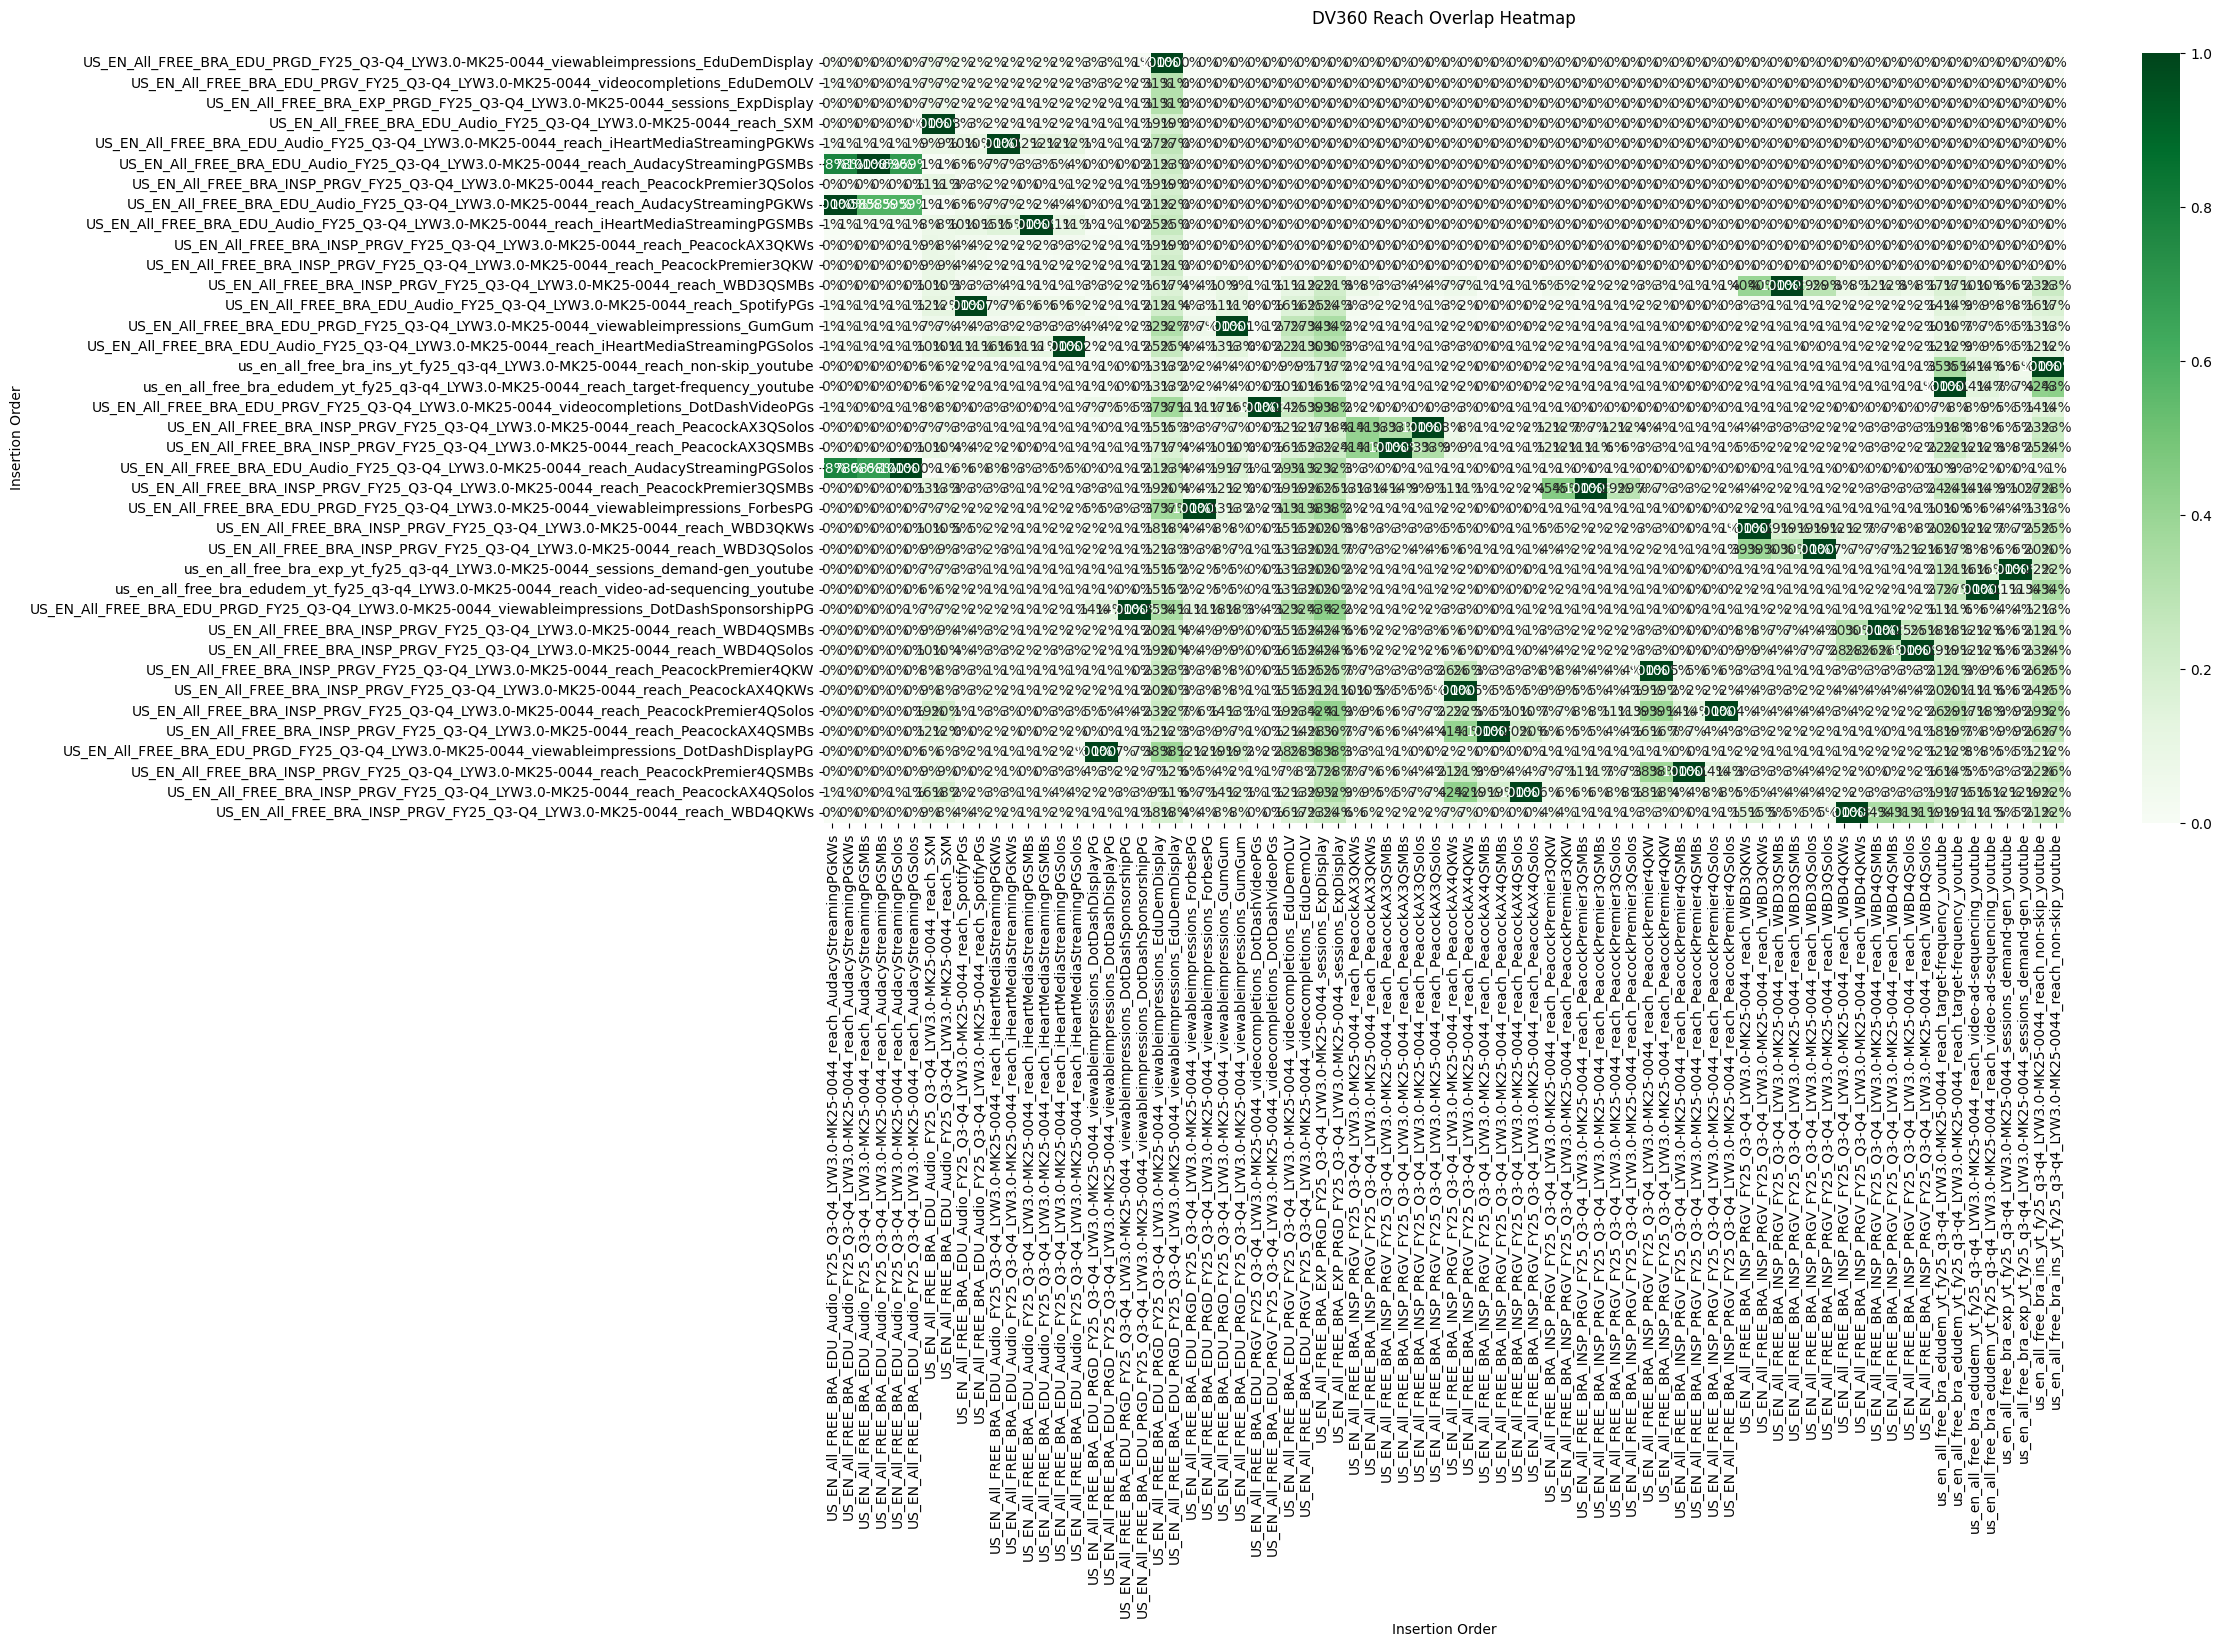

In [ ]:
# @title
try:
  overlap_heatmap_df_filtered = filter_io_rows(cleaned_df, INCLUDE_ROWS_CONTAINING, EXCLUDE_ROWS_CONTAINING)
  overlap_heatmap_df_filtered  = filter_io_cols(overlap_heatmap_df_filtered, INCLUDE_COLS_CONTAINING, EXCLUDE_COLS_CONTAINING)

  #control flow for figure size
  if FILTERED_IOS_HEATMAP_SIZE == 'Small':
    plt.figure(figsize=(10, 5))
  elif FILTERED_IOS_HEATMAP_SIZE == 'Medium':
    plt.figure(figsize=(20, 10))
  else:
    plt.figure(figsize=(30, 20))

  #generate the heatmap, adjust the figsize parameters below to alter the output e.g plt.figure(figsize=(10, 5)) will generate a heatmap with width 10 inches and height 5 inches
  #plt.figure(figsize=(20,10))
  sns.heatmap(overlap_heatmap_df_filtered, cmap="Greens", annot=True, fmt=".0%")
  plt.title("DV360 Reach Overlap Heatmap\n")
  plt.xlabel(COMPARISON_DIMENSION)
  plt.ylabel(COMPARISON_DIMENSION)

  #Screenshot the below visualisation into your deck
  plt.show()
except NameError as e:
  print('Cannot find Reach Overlap % data within your sheet')
  print(f"Invalid input. Details: {e}")


##Gemini AI Reach Overlap Percentage Insights





In [ ]:
# @title

try:
  '''# @title
  import google.generativeai as genai
  import pandas as pd

  from google.colab import userdata
  creds = userdata.get('GOOGLE_API_KEY')

  genai.configure(api_key=creds)

  model = genai.GenerativeModel('gemini-pro')'''

  csv_data = overlap_df.to_csv(index=False)

  prompt = f"""
  Analyze the following DV360 reach overlap data:
  {csv_data}

  Each of the numerical data in the cells of this csv is representing percentage values of users that overlap from that insertion order with the column.

  Lower reach overlap percentages can be good if an advertiser wants to increase their overall unique reach whereas higher reach overlap percentages can be good if an advertiser wants to increase their average frequency.

  Insights are most helpful when relevant to common values in the Insertion order names. Write some insights into this data and give suggestions on budget optimisation based on the level of reach overlap between insertion orders.

  """

  response = client.models.generate_content(
      model="gemini-2.0-flash",
      config=types.GenerateContentConfig(
          system_instruction=sys_instruct),
      contents=prompt)

  reach_overlap_insights = response.text
  print(reach_overlap_insights)
except NameError as e:
  print('Cannot not construct the reach overlap dataframe from the data within your sheet and could therefore not send the Gemini API anything')
  print(f"Invalid input. Details: {e}")

# Email Report

In [ ]:
# @title

try:
  if VENN_DIAGRAM_IO_ONE != '' and VENN_DIAGRAM_IO_TWO != '':
    io_1 = VENN_DIAGRAM_IO_ONE
    io_2 = VENN_DIAGRAM_IO_TWO

    markdown_email = f"""
    ##DV360 Reach Overlap Analysis: {CLIENT_NAME} - {formatted_date}

    Hi {RECEIVER_NAME},

    Please find below a summary of the DV360 reach overlap analysis conducted for your campaigns. This analysis aims to provide insights into the reach and frequency of your campaigns, and to identify potential optimization opportunities.

    ###1. Venn Diagram Analysis (If Applicable)

    **Insert Venn Diagram visual here**


    {vd_insights}

    ###2. Exclusive Reach Analysis

    **Insert Exclusive Reach visual here**


    {exc_reach_insights}

    ###3. Duplicate Reach Analysis

    **Insert Duplicate Reach visual here**


    {dup_reach_insights}

    ###4. Reach Overlap Percentage Analysis

    **Insert Heatmap visual(s) here**


    {reach_overlap_insights}

    Let me know if you have any questions on the above,

    Thanks,

    {YOUR_NAME}

    """
    display(Markdown(markdown_email))

  else:
    markdown_email = f"""
    ## DV360 Reach Overlap Analysis: {CLIENT_NAME} - {formatted_date}

    Hi {RECEIVER_NAME},

    Please find below a summary of the DV360 reach overlap analysis conducted for your campaigns. This analysis aims to provide insights into the reach and frequency of your campaigns, and to identify potential optimization opportunities.


    ### 1. Exclusive Reach Analysis

    **Insert Exclusive Reach visual here**


    {exc_reach_insights}

    ### 2. Duplicate Reach Analysis

    **Insert Duplicate Reach visual here**


    {dup_reach_insights}

    ### 3. Reach Overlap Percentage Analysis

    **Insert Heatmap visual(s) here**


    {reach_overlap_insights}

    Let me know if you have any questions on the above,

    Thanks,

    {YOUR_NAME}

    """
    display(Markdown(markdown_email))
except NameError as e:
  print('Cannot find one or more of the AI insights')
  print(f"Invalid input. Details: {e}")



TIP: You can use Gemini AI to summarise this report further in Gmail, Docs or Gemini itself if it is too verbose. Don't forget to paste over the visualisations
